# 03. 네이버 영화평 감성 분류

- 한글 형태소 분석기 Okt 사용 전처리  

- Keras Tokenizer, pad_sequences 함수 사용

In [1]:
!pip install -q KoNLPy

In [1]:
import numpy as np
import pandas as pd
import re
import time
import matplotlib.pyplot as plt

from konlpy.tag import Okt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, Dense, LSTM

In [2]:
# DATA_TRAIN_PATH = tf.keras.utils.get_file("ratings_train.txt",
#                         "https://github.com/SunaPark-deve/open-source/blob/main/ratings_train.txt")
# DATA_TEST_PATH = tf.keras.utils.get_file("ratings_test.txt",
#                         "https://github.com/SunaPark-deve/open-source/blob/main/ratings_test.txt")

In [3]:
train_data = pd.read_csv("./ratings_train.txt", delimiter='\t')
print(train_data.shape)
train_data.head()

(150000, 3)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
test_data = pd.read_csv("./ratings_test.txt", delimiter='\t')
print(test_data.shape)
test_data.head()

(50000, 3)


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


### 훈련 시간을 감안하여 data size 축소

In [5]:
train_data = train_data.sample(n=50000, random_state=1)
test_data = test_data.sample(n=5000, random_state=1)

print(train_data.shape)
print(test_data.shape)

(50000, 3)
(5000, 3)


**null value 제거**

In [6]:
train_data.dropna(inplace=True)

test_data.dropna(inplace=True)

In [7]:
train_data.isnull().sum(), test_data.isnull().sum()

(id          0
 document    0
 label       0
 dtype: int64,
 id          0
 document    0
 label       0
 dtype: int64)

### okt.morphs()

- 텍스트를 형태소 단위로 나눈다. 옵션으로는 norm과 stem이 있다
- stem은 각 단어에서 어간을 추출하는 기능

In [8]:
okt = Okt()
test = "아버지가방에들어가신다"
okt.morphs(test, stem=True)

['아버지', '가방', '에', '들어가다']

## Text Data 전처리

**한글 문자가 아닌 것 모두 제거**

In [9]:
def preprocessing(sentence, remove_stopwords=True):
    # 불용어 제거
    #stop_words = set(['에', '은', '는', '이', '가', '그리고', '것', '들', '수', '등', '로', '을', '를', '만', '도', '아', '의', '그', '다'])
    stop_words = []

    sentence = re.sub('\\\\n', ' ', sentence)              # 개행문자 제거
    sentence = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣ ]', '', sentence)  #한글외에 모두 제거
    sentence = okt.morphs(sentence, stem=True)
    if remove_stopwords:
        sentence = [token for token in sentence if not token in stop_words]
    return sentence

In [10]:
%%time
train_sentences = []
train_labels = []
test_sentences = []
test_labels = []

start = time.time()

for i, (sent, label) in enumerate(zip(train_data['document'], train_data['label'])):
    if i % 10000 == 0:
        print(f"Train processed = {i}")
    sent = preprocessing(sent)
    if len(sent) > 0:
        train_sentences.append(sent)
        train_labels.append(label)

for i, (sent, label) in enumerate(zip(test_data['document'], test_data['label'])):
    if i % 1000 == 0:
        print(f"Test processed = {i}")
    sent = preprocessing(sent)
    if len(sent) > 0:
        test_sentences.append(sent)
        test_labels.append(label)

print(time.time() - start)

Train processed = 0
Train processed = 10000
Train processed = 20000
Train processed = 30000
Train processed = 40000
Test processed = 0
Test processed = 1000
Test processed = 2000
Test processed = 3000
Test processed = 4000
107.71691608428955
CPU times: total: 1min 22s
Wall time: 1min 47s


## train_labels, test_labels  list를 numpy array 로 변환

In [11]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

print(train_labels.shape)
print(test_labels.shape)

(49571,)
(4951,)


## train_sentences, test_sentences text 를 sequence 로 변환

In [12]:
VOCAB_SIZE = 20000

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(train_sentences)

train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

print(train_sequences[0])
print(test_sequences[0])

[90, 1370, 13, 1554, 80, 520, 8870, 14637, 29, 250, 5, 3884, 16, 430, 62, 210, 30, 1612, 14, 744, 22, 229, 6, 1123, 13, 31, 43, 12, 149, 2547, 5, 741, 12, 1554, 14638, 6007, 8871, 8872, 8, 31]
[1683, 7, 460, 1491, 106, 346, 37, 2485, 344, 760, 206, 650, 96, 270]


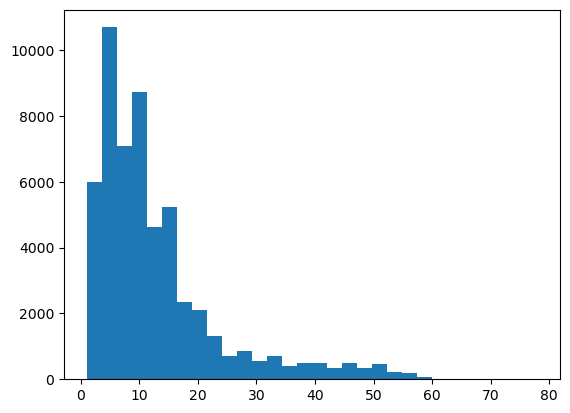

In [13]:
plt.hist([len(s) for s in train_sequences] + [len(s) for s in test_sequences], bins=30);

In [14]:
max_length = 15

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')

test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

print(train_padded.shape)
print(test_padded.shape)
print(train_padded[0])
print(test_padded[0])

(49571, 15)
(4951, 15)
[   90  1370    13  1554    80   520  8870 14637    29   250     5  3884
    16   430    62]
[1683    7  460 1491  106  346   37 2485  344  760  206  650   96  270
    0]


### sequence 를 다시 문장으로 역변환

In [15]:
reverse_word_index = dict([(v, k) for (k, v) in tokenizer.word_index.items()])

def decode_sentence(sequence):
    return ' '.join([reverse_word_index.get(i, '?') for i in sequence])

print(decode_sentence(train_padded[4]))
print()
print(train_sentences[4])

우리나라 용가리 가 배다 더 자다 만들다 이렇다 류 영화 도 개봉 을 하나 보다

['우리나라', '용가리', '가', '배다', '더', '자다', '만들다', '이렇다', '류', '영화', '도', '개봉', '을', '하나', '보다']


In [16]:
model = Sequential([
    Embedding(VOCAB_SIZE+1, 64),
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          1280064   
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1350273 (5.15 MB)
Trainable params: 1350273 (5.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
num_epochs = 30
history = model.fit(train_padded, train_labels, epochs=num_epochs, batch_size=128,
                    validation_data=(test_padded, test_labels), verbose=1)

Epoch 1/30
388/388 [==============================] - 14s 22ms/step - loss: 0.4492 - accuracy: 0.7816 - val_loss: 0.4026 - val_accuracy: 0.8194
Epoch 2/30
388/388 [==============================] - 8s 20ms/step - loss: 0.3287 - accuracy: 0.8600 - val_loss: 0.4088 - val_accuracy: 0.8184
Epoch 3/30
388/388 [==============================] - 7s 19ms/step - loss: 0.2683 - accuracy: 0.8881 - val_loss: 0.4270 - val_accuracy: 0.8196
Epoch 4/30
388/388 [==============================] - 7s 19ms/step - loss: 0.2208 - accuracy: 0.9071 - val_loss: 0.4911 - val_accuracy: 0.8099
Epoch 5/30
388/388 [==============================] - 7s 19ms/step - loss: 0.1842 - accuracy: 0.9232 - val_loss: 0.5379 - val_accuracy: 0.8138
Epoch 6/30
388/388 [==============================] - 8s 20ms/step - loss: 0.1556 - accuracy: 0.9357 - val_loss: 0.6129 - val_accuracy: 0.8097
Epoch 7/30
388/388 [==============================] - 9s 22ms/step - loss: 0.1319 - accuracy: 0.9459 - val_loss: 0.7184 - val_accuracy: 0.808

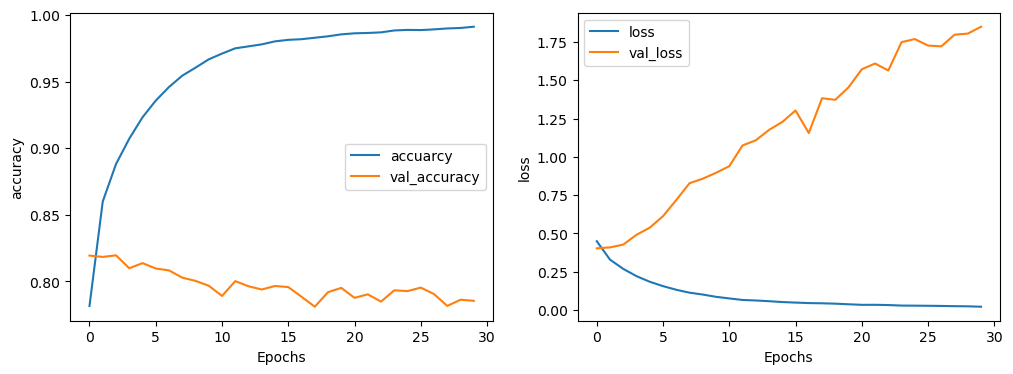

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel('Epochs')
ax1.set_ylabel('accuracy')
ax1.legend(['accuarcy', 'val_accuracy'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('Epochs')
ax2.set_ylabel('loss')
ax2.legend(['loss', 'val_loss'])
plt.show()

In [19]:
test_data.head()

,id,document,label
26247,5933705,크리스마스에 어울리는 시원한 액션. 긴장감과 박진감 넘치는 전개 엄청난 마지막부분,1
35067,5092284,또 봐도 재밌네요 ㅋ2편은 평점이거지네요;;,1
34590,4501201,완전유치뽕짝저질삼류영화..티비편이 훨씬낫다...,0
16668,8848074,이건 보는 영화가 아니다.,0
12196,178689,오랜만에 접한 수작...30대 중반 이상분들에게 추천!,1


In [20]:
sample_text = ['이 영화는 정말 짜증나서 못 보겠다']
# sample_text = ['오랜만에 접한 수작']
sample_seq = tokenizer.texts_to_sequences(sample_text)
sample_padded = pad_sequences(sample_seq, maxlen=max_length, padding='post')
sample_padded

array([[ 2,  1, 21,  1, 49,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [21]:
model.predict([sample_padded])

1/1 [==============================] - 1s 670ms/step


array([[0.04347671]], dtype=float32)

In [22]:
['positive' if model.predict([sample_padded]) >= 0.5 else 'negative']

1/1 [==============================] - 0s 14ms/step


['negative']

In [23]:
model.layers

## Embedding Layer 시각화

- Embedding projector https://projector.tensorflow.org/  를 이용하여 word embedding 시각화

In [24]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(20001, 64)


### embedding layer 의 weight 를 disk 에 write. Embedding projector 사용을 위해 embedding vector file 과 단어가 들어 있는 meta data file 로 구분하여 upload.

In [25]:
out_v = open('vects.tsv', 'w', encoding='utf-8')
out_m = open('meta.tsv', 'w', encoding='utf-8')

for i in range(1, 1000):
    word = tokenizer.index_word.get(i, '?')
    embeddings = weights[i]
    out_m.write(word + '\n')
    out_v.write('\t'.join([str(x) for x in embeddings]) + '\n')

out_v.close()
out_m.close()

## Embedding 결과 확인

[Embedding Projector](https://projector.tensorflow.org) 에 접속하여 embedding 의 품질 확인

Google Colab 의 경우 local PC 로 download 받아 Embedding Projector 에 upload